## Ujian Akhir Semester Deep Learning
<div class="alert alert-warning">
<p>Nama : Rizki Akbar Mahdafiki</p>
<p>NPM : 183112706450071</p>
<p>Kelas : R01</p>
</div>

<div class="alert alert-success">
    Studi kasus yang dibahas adalah data stok pasar "Open" dari Altaba Inc Fund.
    Jumlah data yang digunakan adalah 500 data mulai dari Januari 2006 hingga Desember 2008.
    Dataset yang sebenarnya adalah data yang berisi stok pasar mulai dari Januari 2006 hingga Januari 2018.
    Namun karena datanya terlalu banyak, jadi saya memperkecil datanya menjadi 500 data.
</div>

<div class="alert alert-success">
    Dataset original yang saya gunakan dapat diakses pada website Kaggle
    <pre>kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231</pre>
    Untuk data yang sudah saya edit akan saya cantumkan bersama dengan file ipynb yang saya buat
</div>

## Import semua library dan dataset yang digunakan
Disini saya menggunakan library torch, sklearn, numpy, pandas, dan matplotlib <br>
Untuk dataset saya meng-import dari dataset lokal

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('AABA_2006-01-01_to_2018-01-01_edited.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df)) #Banyak data
df.head()

500


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


<div class="alert alert-success">
    Berikutnya menampilkan data dari dataset dalam bentuk diagram
</div>

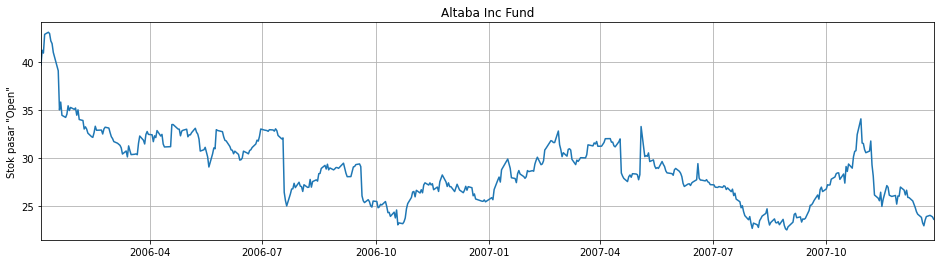

In [29]:
plt.figure(figsize=(16,4))
plt.title('Altaba Inc Fund')
plt.ylabel('Stok pasar "Open"')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Open'])
plt.show()

## Membagi data kedalam "train" dan uji coba set

In [3]:
y = df['Open'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [4]:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 488
Test:  12


## Normalisasi dataset training

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [6]:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 39.69
First item, scaled:  [0.66909267]


## Menyiapkan data untuk model LSTM

In [7]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [8]:
train_data = input_data(train_norm,window_size)
print(f'Train_data: {len(train_data)}')

Train_data: 476


## Mendefinisikan model LSTM dan mengembalikan nilai akhir yang diprediksi

In [9]:
class LSTMnetwork(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size,hidden_size)

        self.linear = nn.Linear(hidden_size,output_size)

        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1] 

In [10]:
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## Mendefinisikan fungsi data "loss" dan fungsi untuk optimasi

In [11]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   256
 16384
   256
   256
    64
     1
______
 17217


## Latih data atau "train" model
Setiap epoch ditampilkan agar mengetahui progress dari training datanya

In [12]:
epochs = 50

import time
start_time = time.time()

for epoch in range(epochs):
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')


Epoch:  1 Loss: 0.01526192
Epoch:  2 Loss: 0.00420195
Epoch:  3 Loss: 0.00040416
Epoch:  4 Loss: 0.00012715
Epoch:  5 Loss: 0.00004574
Epoch:  6 Loss: 0.00000623
Epoch:  7 Loss: 0.00000000
Epoch:  8 Loss: 0.00000117
Epoch:  9 Loss: 0.00000015
Epoch: 10 Loss: 0.00000926
Epoch: 11 Loss: 0.00014006
Epoch: 12 Loss: 0.00022498
Epoch: 13 Loss: 0.00033939
Epoch: 14 Loss: 0.00042763
Epoch: 15 Loss: 0.00054837
Epoch: 16 Loss: 0.00064141
Epoch: 17 Loss: 0.00072473
Epoch: 18 Loss: 0.00079775
Epoch: 19 Loss: 0.00087113
Epoch: 20 Loss: 0.00095809
Epoch: 21 Loss: 0.00100713
Epoch: 22 Loss: 0.00109764
Epoch: 23 Loss: 0.00118879
Epoch: 24 Loss: 0.00128144
Epoch: 25 Loss: 0.00130221
Epoch: 26 Loss: 0.00140666
Epoch: 27 Loss: 0.00148395
Epoch: 28 Loss: 0.00149432
Epoch: 29 Loss: 0.00156669
Epoch: 30 Loss: 0.00169525
Epoch: 31 Loss: 0.00172285
Epoch: 32 Loss: 0.00172136
Epoch: 33 Loss: 0.00185676
Epoch: 34 Loss: 0.00197251
Epoch: 35 Loss: 0.00211870
Epoch: 36 Loss: 0.00254369
Epoch: 37 Loss: 0.00343644
E

## Evaluasi model menggunakan dataset tes

In [13]:
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [14]:
# Run the code below to check your results:
preds[window_size:]

[-0.6847975850105286,
 -0.673287570476532,
 -0.6553864479064941,
 -0.6469815969467163,
 -0.6341017484664917,
 -0.6236813068389893,
 -0.6090002655982971,
 -0.591974139213562,
 -0.5780948996543884,
 -0.5619645714759827,
 -0.5485721826553345,
 -0.5349909663200378]

## Nilai yang sudah diprediksi akan diubah atau di skala ulang

In [30]:
data_prediksi = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [31]:
data_prediksi

array([[25.73816089],
       [25.85677159],
       [26.04124265],
       [26.12785464],
       [26.26058148],
       [26.36796413],
       [26.51925226],
       [26.6947065 ],
       [26.83773206],
       [27.00395509],
       [27.14196366],
       [27.28191809]])

## Membandingkan data asli dengan data prediksi

In [25]:
x = np.arange('2006-07-01', '2007-07-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2006-07-01', '2006-08-01', '2006-09-01', '2006-10-01',
       '2006-11-01', '2006-12-01', '2007-01-01', '2007-02-01',
       '2007-03-01', '2007-04-01', '2007-05-01', '2007-06-01'],
      dtype='datetime64[D]')

<div class="alert alert-success">
    Berikut adalah hasil dari perbandingan dataset asli dengan dataset prediksi
</div>

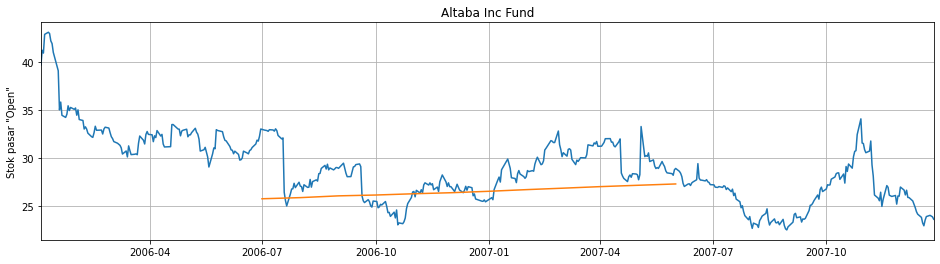

In [33]:
plt.figure(figsize=(16,4))
plt.title('Altaba Inc Fund')
plt.ylabel('Stok pasar "Open"')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Open'])
plt.plot(x, data_prediksi)
plt.show()